### Transfer Learning с kaggle фишками с помощью библиотеки FASTAI

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
import numpy as np

In [3]:
# Делаем change runtime на GPU
torch.cuda.is_available()

True

In [4]:
from google.colab import drive # монтируем гугл диск
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Datasets')

In [0]:
!mkdir dataset_flowers
!mkdir dataset_flowers/train
!mkdir dataset_flowers/valid

In [0]:
!unzip -q flowers-recognition.zip

In [0]:
%cd ..

/content/gdrive/My Drive/Colab Notebooks/Datasets


In [0]:
#move all images to train folder
!mv flowers/* dataset_flowers/train/

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Datasets/dataset_flowers')

In [0]:
path = Path('/content/gdrive/My Drive/Colab Notebooks/Datasets/dataset_flowers')

In [0]:
%ll

total 8
drwx------ 2 root 4096 Mar  5 14:36 train/
drwx------ 2 root 4096 Mar  5 14:36 valid/


In [0]:
classes = os.listdir(path/"train")
for c in classes:
    !mkdir valid/{c}

In [0]:
from random import random

#move some images from training set to validation set for each class
for c in classes:
    for img in os.listdir(path/'train'/c):
        if random() < 0.2:
            !mv train/{c}/{img} valid/{c}/{img}

#check if your images have moved properly
for c in classes:
    imgs = os.listdir(path/'train'/c)
    print(c, len(imgs))
    imgs = os.listdir(path/'valid'/c)
    print(c, len(imgs))

daisy 611
daisy 158
dandelion 828
dandelion 227
rose 636
rose 148
sunflower 597
sunflower 137
tulip 782
tulip 202


In [0]:
os.listdir(path/"train")

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Datasets/dataset_flowers/'

In [0]:
sample = os.listdir(f'{path}valid/rose')[:5]

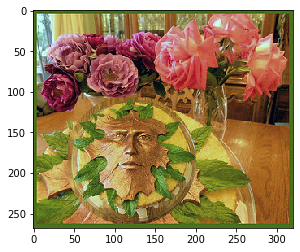

In [11]:
img = plt.imread(f'{path}valid/rose/{sample[2]}')
plt.imshow(img);
#del sample

In [0]:
# Аугментации
tfms = get_transforms(do_flip=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)


In [0]:
# Коллекция изображений
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, seed=42,
                                  ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [14]:
data.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

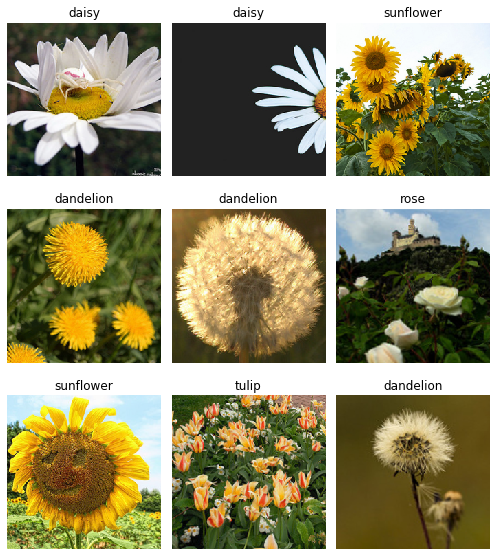

In [15]:
data.show_batch(rows=3, figsize=(7, 8))

In [16]:
from fastai.metrics import error_rate # 1 - accuracy
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate) # ps = 0.5 for dropout

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [17]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4) # 1 cycle-policy learning rate instead of method fit with constant learning rate

epoch,train_loss,valid_loss,error_rate,time
0,1.040640,0.404081,0.128472,08:26
1,0.622304,0.326321,0.104167,00:57
2,0.421993,0.276697,0.087963,00:57
3,0.324092,0.257165,0.081019,00:57


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


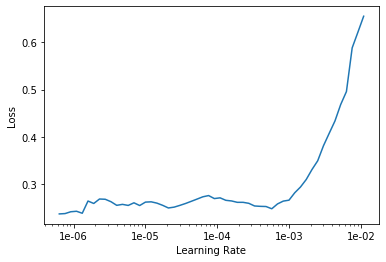

In [0]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4)) 

In [0]:
learn.save('flower-detection-stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

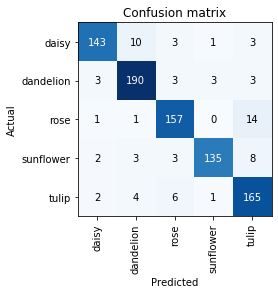

In [0]:
interp.plot_confusion_matrix()

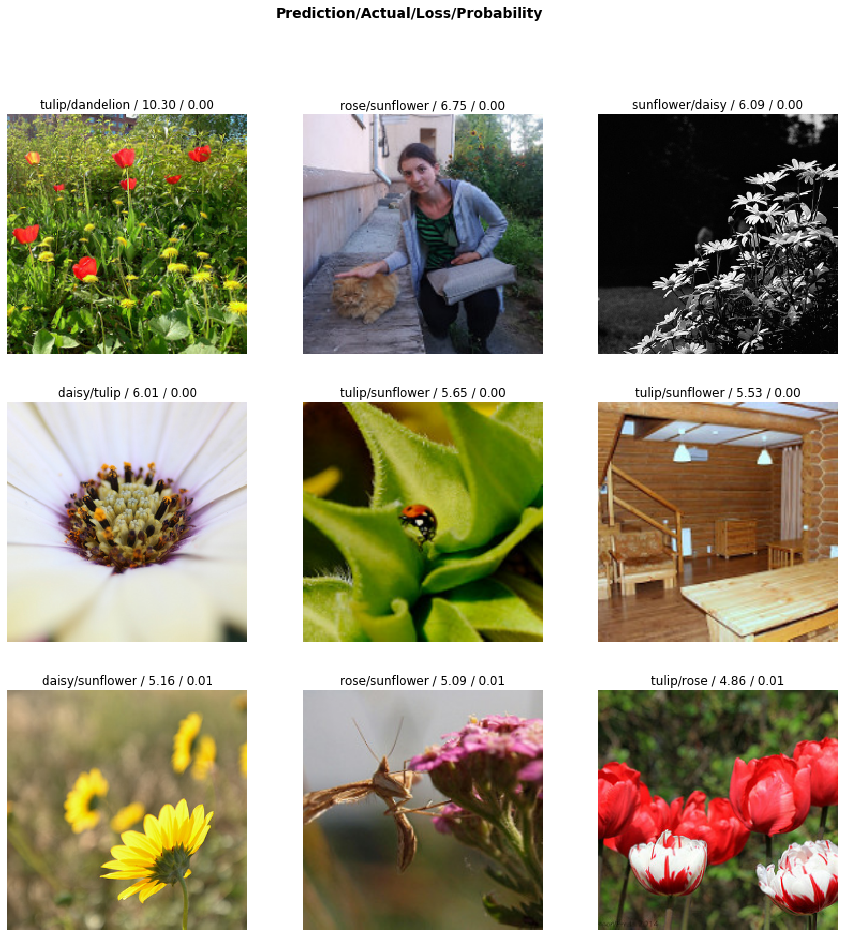

In [0]:
interp.plot_top_losses(9, figsize=(15,15))

### Задание

1. Добавить dropout
2. Добавить тренировку по переменным размерам изображения
3. Добавить cyclic learning rate

https://blog.floydhub.com/ten-techniques-from-fast-ai/